In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

####Importing iris dataset

In [2]:
path='/home/sadat/Documents/DSE/Data/Final_210/iris.data.txt'
df = pd.read_csv(path, names=['sepal length','sepal width','petal length','petal width','class'])
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


####Perform PCA decomposition to 2 components

In [3]:
pca = PCA(n_components=2)
pca.fit(df.ix[:,0:4].values)
X = pca.transform(df.ix[:,0:4].values)

In [4]:
df['V0']=X[:,0]
df['V1']=X[:,1]
df.head()

,sepal length,sepal width,petal length,petal width,class,V0,V1
0,5.1,3.5,1.4,0.2,Iris-setosa,-2.684207,-0.326607
1,4.9,3.0,1.4,0.2,Iris-setosa,-2.715391,0.169557
2,4.7,3.2,1.3,0.2,Iris-setosa,-2.889820,0.137346
3,4.6,3.1,1.5,0.2,Iris-setosa,-2.746437,0.311124
4,5.0,3.6,1.4,0.2,Iris-setosa,-2.728593,-0.333925


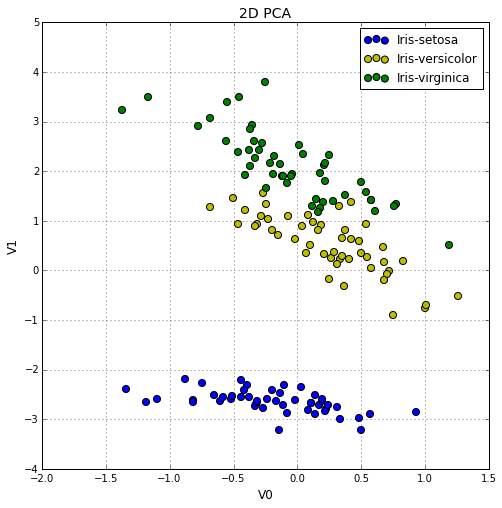

In [5]:
classes = df['class'].unique()
color=['b','y','g']
plt.figure(figsize=(8,8))
plt.xlabel('V0', fontsize = 12)
plt.ylabel('V1', fontsize = 12)
plt.title('2D PCA', fontsize = 14)
for cl, co in zip(classes,color):
    V0 = df[df['class']==cl]['V0'].values
    V1 = df[df['class']==cl]['V1'].values
    plt.scatter(V1,V0, c=co, s=50)
plt.legend(classes)
plt.grid()

We can see that iris-virginica is well separated. 

There is some overlap between iris-vesicolor and iris-virginica.

Based on the 2D plot, separating iris-vesicolor and iris-virginica with our classifier would be a challenge.

####Train with Multivariate Gaussian Classifier

Since we have an equal number of each class, we will not use $\pi$ in our classifier.

Generating the training and test datasets:

In [6]:
#training dataset
df_train = df[df['class']==classes[0]][0:35]
for c in classes[1::]:
    df_train = pd.concat([df_train, df[df['class']==c][0:35]])

#test dataset
df_test = df[df['class']==classes[0]][35::]
for c in classes[1::]:
    df_test = pd.concat([df_test, df[df['class']==c][35::]])

For our classifier, we will use a Multivariate Gaussian.

$$X \sim N_{4}(\mu,\Sigma) $$

As all the classes are of the same size, we will not incorporate $\pi$ into the equation.

$$\pi_{setosa}=\pi_{vesicolor}=\pi_{virginica}$$

We will be using the log of our probability density function to avoid overlfow or underflow.

####Optimize Smoothing

We will try to optimize the classifier using smoothing. This is done by adding a smoothing value, s, to the covariance matrix of the classifier.

$$\Sigma_{smooth} = \Sigma + sI$$

$$X \sim N_{4}(\mu,\Sigma_{smooth})$$

In [7]:
def classify(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values)) + (smooth*np.identity(4))
        func = multivariate_normal(mean=mean, cov=cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    return error

We try to train the dataset and test it against itsef to optimize smoothing.

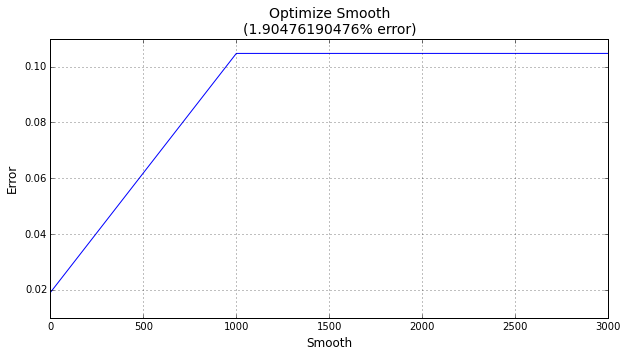

In [8]:
#Initiate x and y
x=[]
y=[]

#Get error values from 1-3000 in steps of 1000
for i in range(0,3001,1000):
    x.append(i)
    y.append(classify(df_train, df_train, i))

#Plot figure
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Smooth', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.title('Optimize Smooth \n('+str(min(y)*100)+'% error)', fontsize = 14)
plt.grid()

We see that smoothing makes our model worse. The best smooth value is 0.

Next, let us analyze the error.

In [9]:
def find_error(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values)) + (smooth*np.identity(4))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    

    #Compare with valid target to get error
    label = []
    flower = []
    probability = []
    prob = np.matrix(prob)
    for i,j,k in zip(max_prob, valid_df['class'], range(len(valid_df))):
        if  classes[i]!=j:
            flower.append(j)
            label.append(classes[i])
            probability.append(prob[:,k])
    return [flower, label, probability]

In [10]:
#Get values
[flower, label, probability] = find_error(df_train, df_train, 0)

In [11]:
#Create dataframe of flowers and predictions
error_dict = {}
error_dict['prediction'] = label
error_dict['flower'] = flower
error_df1 = pd.DataFrame(error_dict)
error_df1.head()

,flower,prediction
0,Iris-versicolor,Iris-virginica
1,Iris-virginica,Iris-versicolor


We can see that the 2 errors in our train dataset were caused by Iris-versicolor and Iris-virginica. This is expected as we have seen overlaps between these 2 classed on our 2D scatter plot. 

Let's look at the probabilities of the first 2 predictions.

In [12]:
#Analyze the probabilities of each specie occuring
error_df2 = pd.DataFrame(probability[0])
error_df2[1] = probability[1]
error_df2.columns = range(2)
error_df2.index=classes
error_df2

,0,1
Iris-setosa,-261.676750,-249.210061
Iris-versicolor,-1.766901,-0.919125
Iris-virginica,-0.441845,-1.020240


We can see that iris-versicolor and iris-virginica are really close in probability. Iris-setosa has an extremely low probability of occuring, as can verified using the 2D scatter plot.

####PCA Decomposition Analysis

Next, we will try to reduce the number of dimensions using PCA decomposition.

$$X \sim N_{4}(\mu,\Sigma) \rightarrow  N_{K}(\mu,\Sigma)$$


We can have 99%+ accuracy with K=2


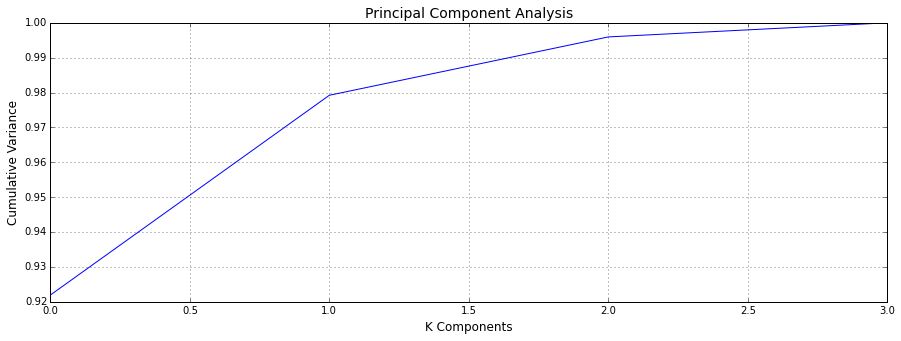

In [13]:
pca = PCA()
x = pca.fit(df_train.ix[:,0:4])
T = pca.transform(df_train.ix[:,0:4])
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(15,5))
plt.plot(cumulative_explained)
plt.xlabel('K Components', fontsize = 12)
plt.ylabel('Cumulative Variance', fontsize = 12)
plt.title('Principal Component Analysis', fontsize = 14)
plt.grid()
print('\nWe can have 99%+ accuracy with K=2')

Now, we will construct a new classifier with PCA decomposition at K=2

$$X \sim N_{4}(\mu,\Sigma) \rightarrow  N_{2}(\mu,\Sigma)$$

In [14]:
def classify_pca(sample_df, valid_df, smooth):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in range(3): 
        cond = sample_df['class']==classes[label]
        mean = np.mean(sample_df[cond].ix[:,5::].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,5::].values)) + (smooth*np.identity(2))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,5::]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)

    #Compare with valid target to get error
    error = np.sum([classes[i]!=j for i,j in zip(max_prob, valid_df['class'])])/len(valid_df)
    return error

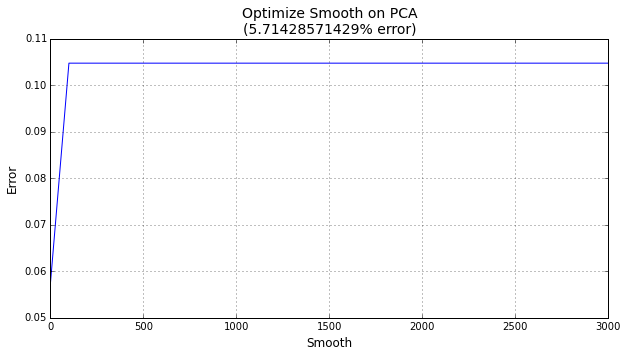

In [20]:
#Initiate x and y
x=[]
y=[]

#Get error values from 1-3000 in steps of 1000
for i in range(0,3001,100):
    x.append(i)
    y.append(classify_pca(df_train, df_train, i))

#Plot figure 
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Smooth', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Optimize Smooth on PCA \n('+str(min(y)*100)+'% error)', fontsize=14)
plt.grid()

It seems that PCA decomposition of K=2 makes our prediction worse.

####Test Dataset

For our final test, we will not use smooth or PCA.

$$X \sim N_{4}(\mu,\Sigma)$$

In [16]:
error = classify(df_train, df_test, 0)

print('Error:\t',error)

Error:	 0.0


We have achieved a 100% accuracy on our test dataset.